In [1]:
# Cell 1: Basic imports and setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import sys

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

sys.path.append('../MCEq')
os.chdir('..')

#import solver related modules
#import primary model choices
import crflux.models as pm

from MCEq.core import MCEqRun
#from MCEq import config
import MCEq.config as config
from MCEq.particlemanager import MCEqParticle

# Configure MCEq database paths
config.mceq_db_fname = "/opt/anaconda3/lib/python3.12/site-packages/MCEq/data/mceq_db_lext_dpm191_v12.h5"
config.decay_db_name = "full_decays"
config.muon_helicity_dependence = True

In [2]:
# Cell 2: Function to run MCEq for different models and angles
def run_mceq_for_model_and_angles(interaction_model, angles_deg):
    """
    Run MCEq for a specific interaction model and set of angles
    Returns fluxes for electron neutrinos
    """
    results = {}
    
    for theta_deg in angles_deg:
        print(f"Running {interaction_model} at {theta_deg}°")
        
        mceq_run = MCEqRun(
            interaction_medium='air',
            interaction_model=interaction_model,
            primary_model=(pm.HillasGaisser2012, 'H3a'),
            theta_deg=theta_deg,
        )
        mceq_run.set_density_model(('MSIS00_IC', ('SouthPole', "October")))
        
        # Solve the cascade equations
        mceq_run.solve()
        
        # Get electron neutrino fluxes (total and conventional)
        mag = 3  # magnitude index
        nue_total = (mceq_run.get_solution("total_nue", mag) + 
                    mceq_run.get_solution("total_antinue", mag))
        nue_conv = (mceq_run.get_solution("conv_nue", mag) + 
                   mceq_run.get_solution("conv_antinue", mag))
        
        results[theta_deg] = {
            'total_nue': nue_total,
            'conv_nue': nue_conv,
            'energy': mceq_run.e_grid
        }
    
    return results

In [3]:
# Cell 3: Define angles and run for both models
# Define angle ranges: 0-45° and 45-90°
angles_0_45 = [0, 15, 30, 45]    # Near-vertical (red)
angles_45_90 = [60, 75, 90]      # Near-horizontal (blue)

# Run for both interaction models
print("Running SIBYLL2.3c...")
sibyll_results = run_mceq_for_model_and_angles('SIBYLL2.3c', angles_0_45 + angles_45_90)

print("\nRunning EPOS-LHC...")
epos_results = run_mceq_for_model_and_angles('EPOS-LHC', angles_0_45 + angles_45_90)

Running SIBYLL2.3c...
Running SIBYLL2.3c at 0°
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'October')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
Running SIBYLL2.3c at 15°
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'October')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 15.00
Running SIBYLL2.3c at 30°
MCEqRun

In [4]:
# Cell 4: Calculate average fluxes for each angular range
def calculate_angular_averages(results, angles_list):
    """Calculate average flux for a list of angles"""
    fluxes_total = []
    fluxes_conv = []
    
    for angle in angles_list:
        fluxes_total.append(results[angle]['total_nue'])
        fluxes_conv.append(results[angle]['conv_nue'])
    
    return {
        'avg_total': np.mean(fluxes_total, axis=0),
        'avg_conv': np.mean(fluxes_conv, axis=0),
        'energy': results[angles_list[0]]['energy']
    }

# Calculate averages for both angular ranges and both models
sibyll_0_45 = calculate_angular_averages(sibyll_results, angles_0_45)
sibyll_45_90 = calculate_angular_averages(sibyll_results, angles_45_90)

epos_0_45 = calculate_angular_averages(epos_results, angles_0_45)
epos_45_90 = calculate_angular_averages(epos_results, angles_45_90)

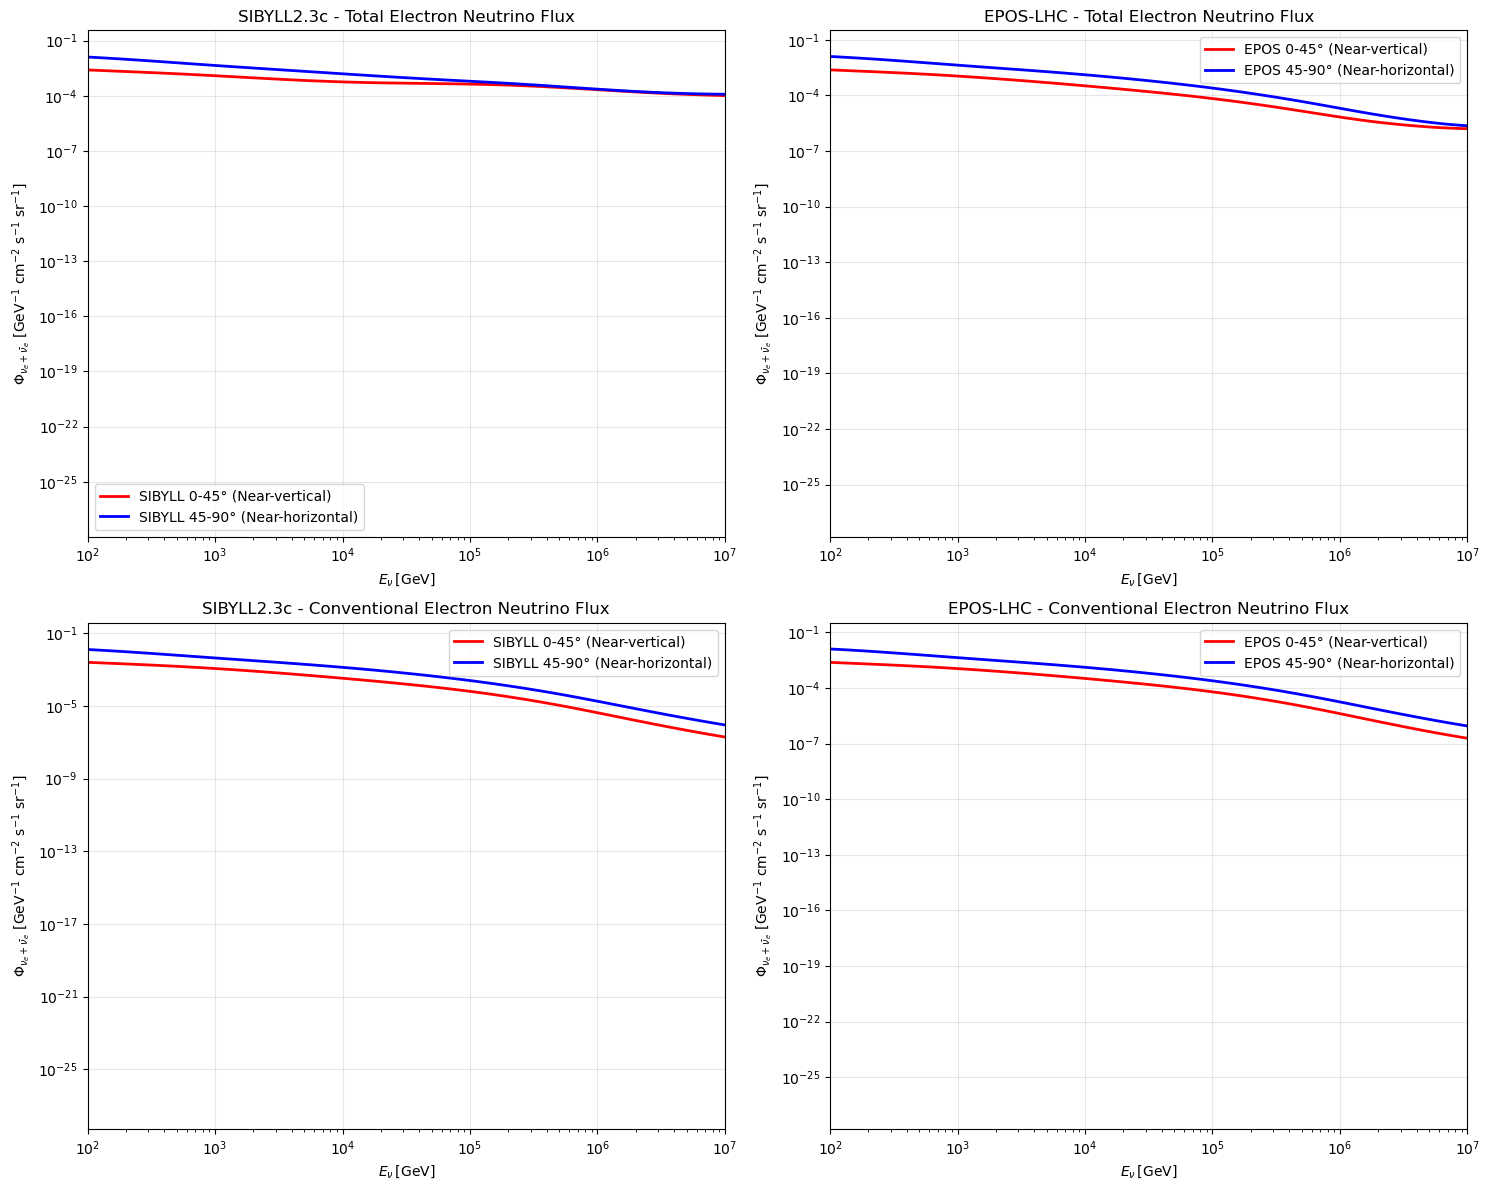

In [5]:
# Cell 5: Plot comparison - SIBYLL vs EPOS for electron neutrinos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
energy = sibyll_0_45['energy']

# Plot 1: SIBYLL - Total electron neutrino flux
ax1 = axes[0, 0]
# 0-45 degrees (red)
ax1.plot(energy, sibyll_0_45['avg_total'], 
         color='red', lw=2, label='SIBYLL 0-45° (Near-vertical)')
# 45-90 degrees (blue)  
ax1.plot(energy, sibyll_45_90['avg_total'], 
         color='blue', lw=2, label='SIBYLL 45-90° (Near-horizontal)')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax1.set_ylabel(r'$\Phi_{\nu_e + \bar{\nu}_e}$ [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax1.set_title('SIBYLL2.3c - Total Electron Neutrino Flux')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1e2, 1e7)

# Plot 2: EPOS - Total electron neutrino flux
ax2 = axes[0, 1]
# 0-45 degrees (red)
ax2.plot(energy, epos_0_45['avg_total'], 
         color='red', lw=2, label='EPOS 0-45° (Near-vertical)')
# 45-90 degrees (blue)
ax2.plot(energy, epos_45_90['avg_total'], 
         color='blue', lw=2, label='EPOS 45-90° (Near-horizontal)')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax2.set_ylabel(r'$\Phi_{\nu_e + \bar{\nu}_e}$ [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax2.set_title('EPOS-LHC - Total Electron Neutrino Flux')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1e2, 1e7)

# Plot 3: SIBYLL - Conventional electron neutrino flux
ax3 = axes[1, 0]
# 0-45 degrees (red)
ax3.plot(energy, sibyll_0_45['avg_conv'], 
         color='red', lw=2, label='SIBYLL 0-45° (Near-vertical)')
# 45-90 degrees (blue)
ax3.plot(energy, sibyll_45_90['avg_conv'], 
         color='blue', lw=2, label='SIBYLL 45-90° (Near-horizontal)')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax3.set_ylabel(r'$\Phi_{\nu_e + \bar{\nu}_e}$ [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax3.set_title('SIBYLL2.3c - Conventional Electron Neutrino Flux')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(1e2, 1e7)

# Plot 4: EPOS - Conventional electron neutrino flux
ax4 = axes[1, 1]
# 0-45 degrees (red)
ax4.plot(energy, epos_0_45['avg_conv'], 
         color='red', lw=2, label='EPOS 0-45° (Near-vertical)')
# 45-90 degrees (blue)
ax4.plot(energy, epos_45_90['avg_conv'], 
         color='blue', lw=2, label='EPOS 45-90° (Near-horizontal)')

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax4.set_ylabel(r'$\Phi_{\nu_e + \bar{\nu}_e}$ [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
ax4.set_title('EPOS-LHC - Conventional Electron Neutrino Flux')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(1e2, 1e7)

plt.tight_layout()
plt.show()

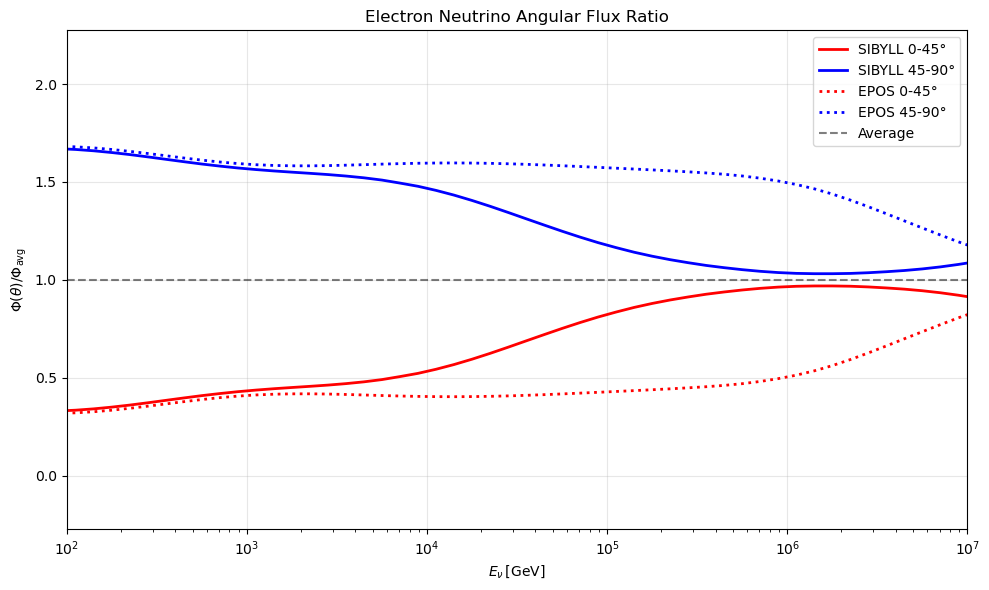

In [6]:
# Cell 5: Plot with angular flux ratio
fig, ax = plt.subplots(figsize=(10, 6))

energy = sibyll_0_45['energy']

# Calculate ratios: angular bin flux / total average flux
total_avg_sibyll = (sibyll_0_45['avg_total'] + sibyll_45_90['avg_total']) / 2
total_avg_epos = (epos_0_45['avg_total'] + epos_45_90['avg_total']) / 2

# SIBYLL - solid lines
# 0-45 degrees (red solid)
ax.plot(energy, sibyll_0_45['avg_total'] / total_avg_sibyll, 
        color='red', lw=2, linestyle='-', label='SIBYLL 0-45°')

# 45-90 degrees (blue solid)  
ax.plot(energy, sibyll_45_90['avg_total'] / total_avg_sibyll, 
        color='blue', lw=2, linestyle='-', label='SIBYLL 45-90°')

# EPOS - dotted lines
# 0-45 degrees (red dotted)
ax.plot(energy, epos_0_45['avg_total'] / total_avg_epos, 
        color='red', lw=2, linestyle=':', label='EPOS 0-45°')

# 45-90 degrees (blue dotted)
ax.plot(energy, epos_45_90['avg_total'] / total_avg_epos, 
        color='blue', lw=2, linestyle=':', label='EPOS 45-90°')

# Add reference line at y=1
ax.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Average')

ax.set_xscale('log')
ax.set_xlabel(r'$E_{\nu}\,[\mathrm{GeV}]$')
ax.set_ylabel(r'$\Phi(\theta) / \Phi_{\mathrm{avg}}$')
ax.set_title('Electron Neutrino Angular Flux Ratio')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(1e2, 1e7)

plt.tight_layout()
plt.show()